<a href="https://colab.research.google.com/github/KJ22222/ESSA/blob/main/11_11%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7 문서 군집화 소개와 실습(Opinion Review 데이터 세트)
- 비슷한 텍스트 구성의 문서를 군집화하는것
- 동일한 군집에 속하는문서를 같은 카테고리 소속으로 분류
- 비지도 학습
- 이전장에서 배운 군집화 기법을 활용

##Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기

In [2]:
import pandas as pd
import glob ,os

# 아래는 제 컴퓨터에서 압축 파일을 풀어 놓은 디렉토리이니, 여러분의 디렉토리를 설정해 주십시요  
path = r'C:\Users\user\Downloads\OpinosisDataset1.0\OpinosisDataset1.0\topics'                     
# path로 지정한 디렉토리 밑에 있는 모든 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일들의 파일명은 filename_list 리스트로 취합, 
# 개별 파일들의 파일내용은 DataFrame로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취합 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    
    # 절대경로로 주어진 file 명을 가공. 만일 Linux에서 수행시에는 아래 \\를 / 변경. 맨 마지막 .data 확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]

    #파일명 리스트와 파일내용 리스트에 파일명과 파일 내용을 추가. 
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 리스트와 파일내용 리스트를  DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text


- tf-idf 형태로 피처 벡터화
  - LemToken 사용
  - min_df,max_df 범위를 설정하여 피처 개수 제한

In [3]:

from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

- 변환된 피처 벡터화 행렬 데이터에 대해서 군집화를 수행->K-평균
 - 5개의 중심 기반으로 군집화
 - 최대 반복 횟수 10000
 - KMEABS를 수행한 후 군집에 라벨 값과 중심별로 할당된 데이터 세트의 좌표 값 구함

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

ValueError: ignored

In [5]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

NameError: ignored

- 할당된 군집의 레이블을 함께 가지고 있는 데이터 만들기

In [ ]:
document_df['cluster_label'] = cluster_label
document_df.head()

- sort_values(by=정렬칼럼명')이렇게 하면 정렬칼럼명으로 데이터 정렬할 수 있음


In [ ]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

->0은 호텔에 대한 분류

In [ ]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

->1은 킨들,아이팟등 포터블 전자기기에 대한 리뷰

In [ ]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

->2는 차량용 네비게이션으로 군집 구성

In [ ]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

->3는 호텔에 대한 리뷰

In [ ]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

->4는 자동차에 대한 리뷰

- 군집 개수가 약간 많게 설정돼 있어서 세분화되어 군집화됨->3개로 나눔


In [ ]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

##군집(Cluster)별 핵심 단어 추출하기
- KMEANS는 각 군집을 구성하는 단어 피처가 군집의 중심을 기준으로 얼마나 가깝게 위치해 있는지 ```cluster_centers_```제공
- 행은 개별 군집을 열을 개별 피처를

In [ ]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

->군집 3개 피처 2409개

In [ ]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

In [ ]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [ ]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,\
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

-> 각 군집별로 어떤 단어가 주로 분류에 사용되었는지 확인 가능

#10.Text Analysis 실습 _ 캐글 Mercari Price Suggestion Challenge

- item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행하는것이 차이점

##데이터 전처리

In [6]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [7]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


->brand_name의 경우 많은 null값,category_name 도 약간 가지고 있음

- target 값인 price 칼럼의 데이터 분포도 살펴보기
- 회귀의 경우 정규분포도가 중요하므로 로그 씌워서 변환

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


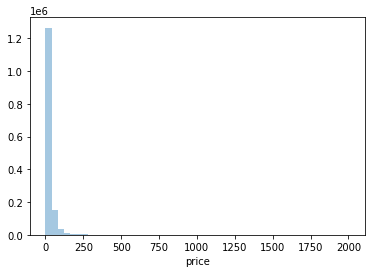

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

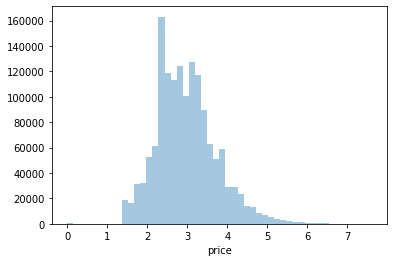

In [9]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

- 로그값 변환한거로 대체

In [11]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    1.223156
1    1.603479
2    1.223156
Name: price, dtype: float64

- 다른 피처 값들 살펴보기

In [12]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


->Shipping은 배송비 유뮤이며 값이 비교적 균일

- 묘사 칼럼에서 별도 설명 없는경우가 몇개인지 살펴보기

In [13]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- category_name의 /를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘 학습

In [14]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


-> 대분류 여러개,중분류 114개,소분류 817개

In [15]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

- 다른 칼럼들은 null값에 Other_Null로 채우기
- brand name의 경우 중요한 칼럼이므로 다른 값을 대체하지 않음

##피처 인코딩(숫자형)과 피처 벡터화(텍스트형)
- 문자열 칼럼 중 레이블 또는 원핫인코딩 수행
- 피처 벡터화로 변환할 칼럼 선별
- 피처 벡터화의 경우 짧은건 count기반의 벡터화,긴건 td-idf 기반의 벡터화

In [16]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


-> 명료한 문자열로 되어 있으므로 인코딩 변환 적용

- name 칼럼 알아보기

In [17]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


-> 종류가 1225273가지 속성은 유형이 매우 많고 적은 단어 위주의 텍스트 형태로 되어있으므로 count 기반의 벡터화 변환 적용

- item_description칼럼에서 문자열 크기와 2개 정도의 텍스트만 추출해보기

In [18]:

pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

->tf-idf 변환

- name과 item_description은 피처 벡터화

In [19]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizer,TfidfVectorizer가 fit_transform을 통해 반환하는 데이터는 희소 행렬 형태
- X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성하고 앞으로 인코딩 죌 칼럼들도 결합돼 ml모델을 실행하는 기반 데이터 세트로 재구성돼야함
- LabelBinarizer은 희소 행렬 형태의 원핫 인코딩을 변환

In [20]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

->칼럼들이 많이 생겼지만 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제 x

- 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()이용해 모두 결합

In [22]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


66

##릿지 회귀 모델 구축 및 평가

- price를 로그변환하여 학습했으ㅁ니까 다시 로그의 역변환인 지수변환을 수행해 원복해야함

In [23]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [24]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

- 묘사가 가격 예측에 어떤 영향을 미치는지 확인하기 위해서 포함했을때와 안 했을때 비교해서 

In [27]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_p))

Item Description을 제외했을 때 rmsle 값: 0.1279903821430385


NameError: ignored

->중요한 영향을 미치고 있음을 확인할 수 있음

##LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

->앞보다 성능이 나아짐

- 위의 것과 앙상블하여 최종 예특 결괏값을 도출

In [ ]:

preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

->앙상블로 더 개선